In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

# 데이터 수집

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'
sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

데이터 병합

In [4]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


# 데이터 분석

resumetable

In [5]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary
resumetable(train)

데이터 세트 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


데이터 시각화

일별 판매량

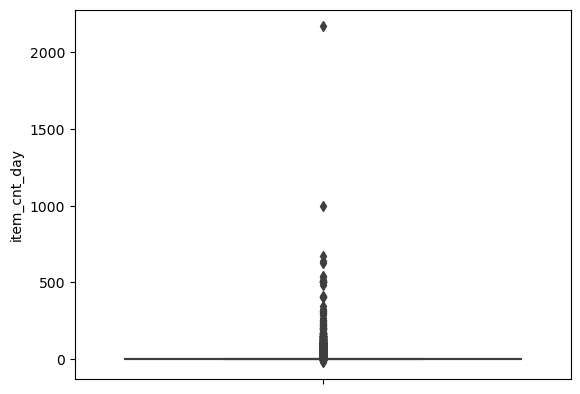

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=train);

상품 가격

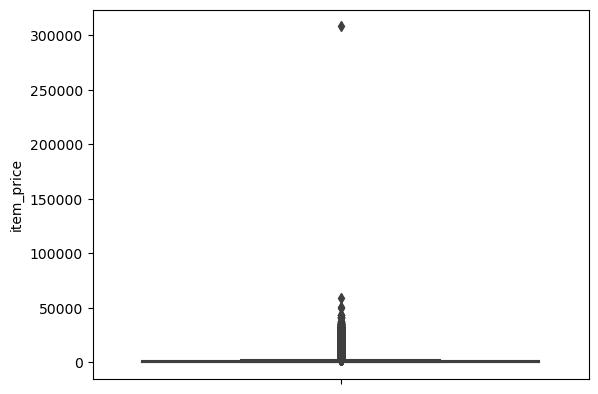

In [7]:
sns.boxplot(y='item_price', data=train);

그룹화

In [8]:
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index() # 인덱스 재설정

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


월별 판매량

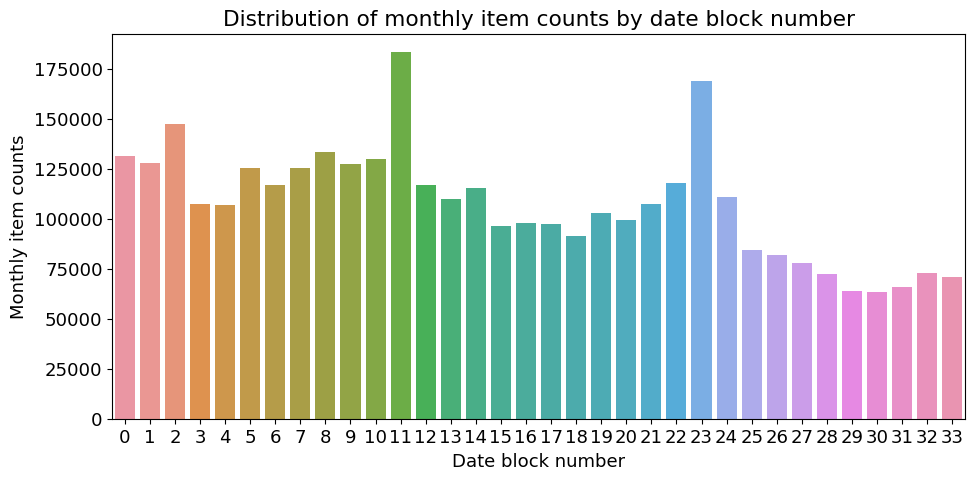

In [9]:
mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

상품분류별 판매량

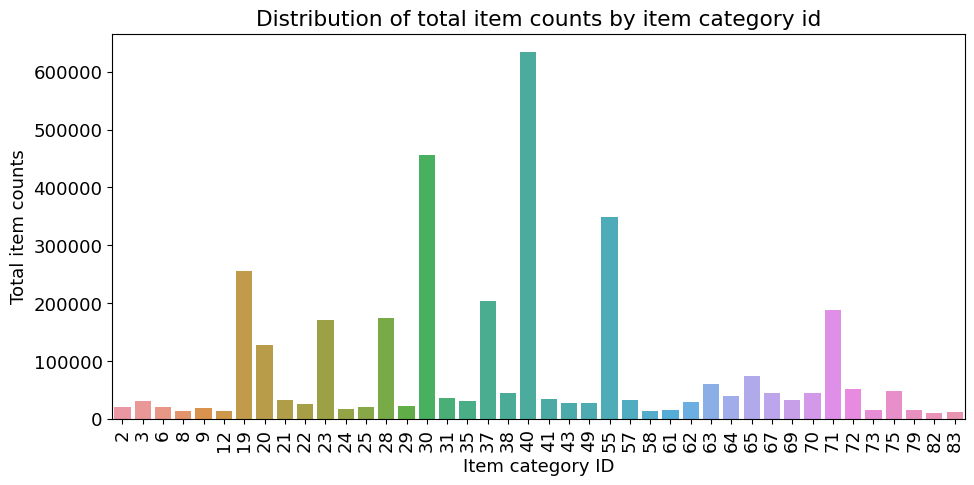

In [10]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 총 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 회전


상점별 판매량

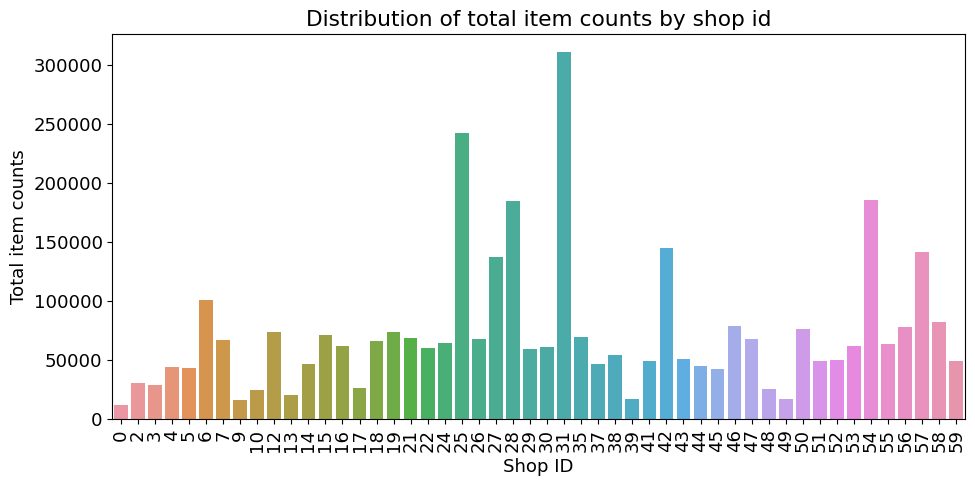

In [11]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

# 베이스라인 모델

피처 엔지니어링 I : 피처명 한글화

In [12]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [15]:
item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


피처 엔지니어링 II : 데이터 다운캐스팅

In [16]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [17]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


피처 엔지니어링 III : 데이터 조합 생성

In [18]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


피처 엔지니어링 IV : 타깃값(월간 판매량) 추가

In [19]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = sales_train.groupby(idx_features).agg({'판매량': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns={'판매량': '월간 판매량'})

group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [20]:
# train과 group 병합하기
train = train.merge(group, on=idx_features, how='left')

train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


In [21]:
import gc # 가비지 컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정
gc.collect(); # 가비지 컬렉션 수행

 피처 엔지니어링 V : 테스트 데이터 이어붙이기

In [22]:
test['월ID'] = 34

In [23]:
# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, # 기존 인덱스 무시(0부터 새로 시작)
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

In [24]:
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data

,월ID,상점ID,상품ID,월간 판매량,shop_id,item_id
0,0,59.0,22154.0,1.0,0.0,0.0
1,0,59.0,2552.0,0.0,0.0,0.0
2,0,59.0,2554.0,0.0,0.0,0.0
3,0,59.0,2555.0,0.0,0.0,0.0
4,0,59.0,2564.0,0.0,0.0,0.0
...,...,...,...,...,...,...
11128045,34,0.0,0.0,0.0,45.0,18454.0
11128046,34,0.0,0.0,0.0,45.0,16188.0
11128047,34,0.0,0.0,0.0,45.0,15757.0
11128048,34,0.0,0.0,0.0,45.0,19648.0


피처 엔지니어링 VI : 나머지 데이터 병합(최종 데이터 생성

In [25]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

48.1% 압축됨


In [26]:
all_data = all_data.drop(['상점명', '상품명', '상품분류명'], axis=1)

피처 엔지니어링 VII : 마무리

In [27]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [28]:
del all_data
gc.collect();

# 모델 훈련 및 성능 검증

In [29]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', # 평가지표 = rmse
          'num_leaves': 255,
          'learning_rate': 0.01,
          'force_col_wise': True,
          'random_state': 10}

# 범주형 피처 설정
cat_features = ['상점ID', '상품분류ID']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      verbose_eval=50)  

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['상점ID', '상품분류ID']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
[LightGBM] [Info] Start training from score 0.299125


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	training's rmse: 1.14777	valid_1's rmse: 1.06755
[100]	training's rmse: 1.11425	valid_1's rmse: 1.0386
[150]	training's rmse: 1.09673	valid_1's rmse: 1.02671
[200]	training's rmse: 1.08573	valid_1's rmse: 1.02027
[250]	training's rmse: 1.07722	valid_1's rmse: 1.01661
[300]	training's rmse: 1.0698	valid_1's rmse: 1.0138
[350]	training's rmse: 1.06317	valid_1's rmse: 1.01084
[400]	training's rmse: 1.05734	valid_1's rmse: 1.00936
[450]	training's rmse: 1.05224	valid_1's rmse: 1.00818
[500]	training's rmse: 1.04792	valid_1's rmse: 1.00722


예측 및 결과 제출

In [30]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)
# 제출 파일 생성
# submission['item_cnt_month'] = preds
# submission.to_csv('submission.csv', index=False)

In [31]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

# 모델 성능 개선

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'
sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

# 9.4.1 피처 엔지니어링 I : 피처명 한글화와 데이터 다운캐스팅

In [33]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [34]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


# 9.4.2 피처 엔지니어링 II : 개별 데이터 피처 엔지니어링

sales_train 이상치 제거 및 전처리

In [35]:
# 판매가가 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매가'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매가'] < 50000]

# 판매량이 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매량'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매량'] < 1000]

In [36]:
print(shops['상점명'][0], '||', shops['상점명'][57])
print(shops['상점명'][1], '||', shops['상점명'][58])
print(shops['상점명'][10], '||', shops['상점명'][11])
print(shops['상점명'][39], '||', shops['상점명'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [37]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

shops 파생 피처 생성 및 인코딩

In [38]:
shops['도시'] = shops['상점명'].apply(lambda x: x.split()[0])

In [39]:
shops['도시'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [40]:
shops.loc[shops['도시'] =='!Якутск', '도시'] = 'Якутск'

In [41]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
shops['도시'] = label_encoder.fit_transform(shops['도시'])

In [42]:
# 상점명 피처 제거
shops = shops.drop('상점명', axis=1)

shops.head()

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


itmes 파생 피처 생성

In [43]:
# 상품명 피처 제거
items = items.drop(['상품명'], axis=1)

In [44]:
# 상품이 맨 처음 팔린 날을 피처로 추가
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID': 'min'})['월ID']

items.head()

,상품ID,상품분류ID,첫 판매월
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [45]:
items[items['첫 판매월'].isna()]

# 첫 판매월 피처의 결측값을 34로 대체
items['첫 판매월'] = items['첫 판매월'].fillna(34)

item_categories 파생 피처 생성 및 인코딩

In [46]:
# 상품분류명의 첫 단어를 대분류로 추출
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x: x.split()[0])  
item_categories['대분류'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: 대분류, dtype: int64

In [47]:
def make_etc(x):
    if len(item_categories[item_categories['대분류']==x]) >= 5:
        return x
    else:
        return 'etc'

# 대분류의 고윳값 개수가 5개 미만이면 'etc'로 바꾸기
item_categories['대분류'] = item_categories['대분류'].apply(make_etc)

In [48]:
item_categories.head()

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [49]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

# 상품분류명 피처 제거
item_categories = item_categories.drop('상품분류명', axis=1)

# 9.4.3 피처 엔지니어링 III : 데이터 조합 및 파생 피처 생성

데이터 조합

In [50]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

파생 피처 생성

In [51]:
group = sales_train.groupby(idx_features).agg({'판매량': 'sum',
                                               '판매가': 'mean'})
group = group.reset_index()
group = group.rename(columns={'판매량': '월간 판매량', '판매가': '평균 판매가'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [52]:
import gc

# group 변수 가비지 컬렉션
del group
gc.collect();

In [53]:
# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량': 'count'})
group = group.reset_index()
group = group.rename(columns={'판매량': '판매건수'})

train = train.merge(group, on=idx_features, how='left')

# 가비지 컬렉션
del group, sales_train
gc.collect()

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


# 9.4.4 피처 엔지니어링 IV : 데이터 합치기

테스트 데이터 이어붙이기

In [54]:
# 테스트 데이터 월ID를 34로 설정
test['월ID'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


모든 데이터 병합

In [55]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

64.6% 압축됨


# 9.4.5 피처 엔지니어링 V : 시차 피처 생성

기준 피처별 월간 평균 판매량 파생 피처 생성`

In [56]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인 
    assert (idx_features[0] == '월ID') and \
           len(idx_features) in [2, 3]
    
    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'월간 판매량': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량': feature_name})
    
    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)
    
    # 가비지 컬렉션
    del group
    gc.collect()
    
    return df, mean_features

In [57]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])

In [58]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [59]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['월ID', '상점ID', '상품분류ID'])

In [60]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

시차 피처 생성 원리와 구현

In [61]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
    df_temp = df[idx_features + [lag_feature]].copy() 

    # 시차 피처 생성 
    for i in range(1, nlags+1):
        # 시차 피처명 
        lag_feature_name = lag_feature +'_시차' + str(i)
        # df_temp 열 이름 설정 
        df_temp.columns = idx_features + [lag_feature_name]
        # df_temp의 date_block_num 피처에 1 더하기 
        df_temp['월ID'] += 1
        # idx_feature를 기준으로 df와 df_temp 병합하기 
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # 결측값 0으로 대체 
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # 데이터 다운캐스팅
    df = downcast(df, False)
    # 가비지 컬렉션
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

시차 피처 생성 I : 월간 판매량

In [62]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='월간 판매량', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [63]:
all_data.head().T

,0,1,2,3,4
월ID,0.000000,0.000000,0.000000,0.000000,0.000000
상점ID,59.000000,59.000000,59.000000,59.000000,59.000000
상품ID,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
월간 판매량,1.000000,0.000000,0.000000,0.000000,0.000000
평균 판매가,999.000000,0.000000,0.000000,0.000000,0.000000
판매건수,1.000000,0.000000,0.000000,0.000000,0.000000
도시,30.000000,30.000000,30.000000,30.000000,30.000000
상품분류ID,37.000000,58.000000,58.000000,56.000000,59.000000
첫 판매월,0.000000,0.000000,0.000000,0.000000,0.000000
대분류,5.000000,7.000000,7.000000,7.000000,7.000000


In [64]:
lag_features_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

시차 피처 생성 II : 판매건수, 평균 판매가

In [65]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='판매건수', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='평균 판매가', 
                                                  nlags=3)

시차 피처 생성 III : 평균 판매량

In [66]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [67]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['월ID', '상점ID', '상품분류ID'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

시차 피처 생성 마무리 : 결측값 처리

In [68]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index)

# 9.4.6 피처 엔지니어링 VI : 기타 피처 엔지니어링

기타 피처 추가
- 월간 판매량 시차 피처들의 평균

In [69]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                          '월간 판매량_시차2', 
                                          '월간 판매량_시차3']].mean(axis=1)

In [70]:
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

시차 변화량

In [71]:
all_data['시차변화량1'] = all_data['월간 판매량_시차1']/all_data['월간 판매량_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2']/all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

신상 여부 & 첫 판매 후 경과 기간

In [72]:
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID']
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

월(month)

In [73]:
all_data['월'] = all_data['월ID'] % 12

필요 없는 피처 제거

In [74]:
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(['첫 판매월', '평균 판매가', '판매건수'], axis=1)

In [75]:
all_data = downcast(all_data, False) # 데이터 다운캐스팅

# 9.4.7 피처 엔지니어링 VII : 마무리

In [76]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9904582 entries, 1122386 to 11026967
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int8   
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int8   
 8   월간 판매량_시차2               int8   
 9   월간 판매량_시차3               int8   
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float32
 14  평균 판매가_시차2               float32
 15  평균 판매가_시차3               float32
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상

In [77]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']

# 가비지 컬렉션
del all_data
gc.collect();

# 9.4.8 모델 훈련 및 성능 검증¶

In [78]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', 
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['대분류', '도시', '상점ID', '상품분류ID', '월']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 9452298, number of used features: 30


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.297707
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01073	valid_1's rmse: 0.986993
[200]	training's rmse: 0.909083	valid_1's rmse: 0.922887
[300]	training's rmse: 0.857505	valid_1's rmse: 0.898233
[400]	training's rmse: 0.829175	valid_1's rmse: 0.888136
[500]	training's rmse: 0.810627	valid_1's rmse: 0.884038
[600]	training's rmse: 0.796874	valid_1's rmse: 0.882521
[700]	training's rmse: 0.786815	valid_1's rmse: 0.882318
[800]	training's rmse: 0.778893	valid_1's rmse: 0.882091
[900]	training's rmse: 0.772392	valid_1's rmse: 0.881891
[1000]	training's rmse: 0.76691	valid_1's rmse: 0.881599
[1100]	training's rmse: 0.76187	valid_1's rmse: 0.881711
Early stopping, best iteration is:
[999]	training's rmse: 0.766974	valid_1's rmse: 0.881574


# 9.4.9 예측 및 결과 제출

In [79]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)

# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission_01.csv', index=False)

# del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
# gc.collect();